# Import the libraries for CNN ML

In [1]:
#import the libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image

# Load the dataset

In [2]:
def load_dataset(directory, img_width, img_height):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=0.2,  
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        brightness_range=[0.8, 1.2],
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
    )

    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_width, img_height),
        batch_size=32,
        color_mode='rgb',
        class_mode='categorical',)

    return generator

# Create the Model

Here We use ResNet-18, ResNet-50 which we built on our own, and ResNet-50V2 with the help of Keras pre-trained model for our training dataset. Without the pre_trained model, the model will take a lot of time to train. Due to the lack of dataset, we cannot train the model as good as the pre-trained model.  
Here is the demonstration of the structure for ResNet  
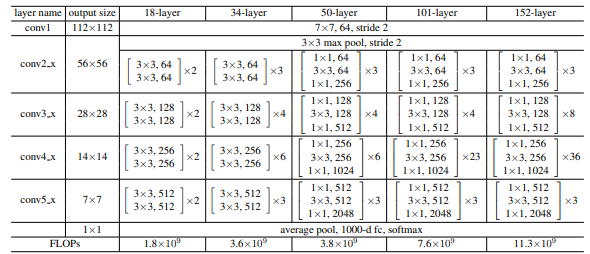

In [3]:
# Model with ResNet50V2
def create_model_RestNet50V2(input_shape, num_classes):
    # load the base model
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)

    # freeze the base model
    base_model.trainable = False

    # create new model on top
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # build the model
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    # compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
import tensorflow as tf

def conv_block_ResNet18(inputs, filters, kernel_size=3, strides=1):
    # Apply a Convolutional layer
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(inputs)
    # Apply Batch Normalization
    x = tf.keras.layers.BatchNormalization()(x)
    # Apply ReLU activation function
    x = tf.keras.layers.Activation('relu')(x)
    return x

def identity_block_ResNet18(inputs, filters):
    # First convolutional block
    x = conv_block_ResNet18(inputs, filters)
    # Second convolutional block
    x = conv_block_ResNet18(x, filters)
    # Add input (residual) to the output of the convolutional blocks
    x = tf.keras.layers.Add()([x, inputs])
    # Apply ReLU activation function
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_model_ResNet18(input_shape, num_classes):
    # Define the input tensor
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Initial convolutional block (Stage 0)
    x = conv_block_ResNet18(inputs, 64, kernel_size=7, strides=2)
    # Initial Max Pooling
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # ResNet-18 comprises 4 stages, each with a convolutional and identity block

    # Stage 1
    x = conv_block_ResNet18(x, 64)
    x = identity_block_ResNet18(x, 64)

    # Stage 2
    x = conv_block_ResNet18(x, 128, strides=2)
    x = identity_block_ResNet18(x, 128)

    # Stage 3
    x = conv_block_ResNet18(x, 256, strides=2)
    x = identity_block_ResNet18(x, 256)

    # Stage 4
    x = conv_block_ResNet18(x, 512, strides=2)
    x = identity_block_ResNet18(x, 512)

    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Dropout layer for regularization
    x = tf.keras.layers.Dropout(0.2)(x)

    # Dense layer for classification
    x = tf.keras.layers.Dense(units=num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=x)

    # Compile the model with loss function, optimizer, and metrics
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  metrics=['accuracy'])

    return model



In [5]:
# Model with ResNet50
def create_model_ResNet50(input_shape, num_classes):
    # Using ResNet-50 as the base model
    inputs = tf.keras.layers.Input(shape=input_shape)

    # zero-padding
    x = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # add the residual block
    # stage 1
    x = conv_block(x, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    # stage 2
    x = conv_block(x, filters=[128, 128, 512], strides=(2, 2))
    x = identity_block(x, filters=[128, 128, 512])
    x = identity_block(x, filters=[128, 128, 512])
    x = identity_block(x, filters=[128, 128, 512])



    # stage 3
    x = conv_block(x, filters=[256, 256, 1024], strides=(2, 2))
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])

    # stage 4
    x = conv_block(x, filters=[512, 512, 2048], strides=(2, 2))
    x = identity_block(x, filters=[512, 512, 2048])
    x = identity_block(x, filters=[512, 512, 2048])

    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dropout(0.2)(x)

    # Dense
    x = tf.keras.layers.Dense(units=num_classes, activation='softmax')(x)

    # Build the model
    model = tf.keras.Model(inputs=inputs, outputs=x)

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                    metrics=['accuracy'])

    return model

def identity_block(inputs, filters):
    filters1, filters2, filters3 = filters

    x = tf.keras.layers.Conv2D(filters1, (1, 1), padding='valid')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters2, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters3, (1, 1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Add()([x, inputs])
    x = tf.keras.layers.Activation('relu')(x)

    return x

def conv_block(inputs, filters, strides):
    filters1, filters2, filters3 = filters

    x = tf.keras.layers.Conv2D(filters1, (1, 1), strides=strides, padding='valid')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters2, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters3, (1, 1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    shortcut = tf.keras.layers.Conv2D(filters3, (1, 1), strides=strides, padding='valid')(inputs)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)

    return x

# Plot the map

In [6]:
def plot_history(history):
    fig = plt.figure(num=1, figsize=(14,5))
    
    ax1 = fig.add_subplot(211)   
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curve')
    
    ax2 = fig.add_subplot(212)
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Curve')

# Main Program

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

d:\anaconda3\envs\mlaenv\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9/9 [==============================] - 35s 4s/step - loss: 1.1064 - accuracy: 0.7070 - val_loss: 0.4642 - val_accuracy: 0.8769
Epoch 2/10
9/9 [==============================] - 29s 3s/step - loss: 0.5134 - accuracy: 0.8472 - val_loss: 0.3065 - val_accuracy: 0.9077
Epoch 3/10
9/9 [==============================] - 28s 3s/step - loss: 0.1574 - accuracy: 0.9524 - val_loss: 0.4240 - val_accuracy: 0.9385
Epoch 4/10
9/9 [==============================] - 28s 3s/step - loss: 0.1525 - accuracy: 0.9524 - val_loss: 0.1667 - val_accuracy: 0.9231
Epoch 5/10
9/9 [==============================] - 26s 3s/step - loss: 0.1060 - accuracy: 0.9597 - val_loss: 0.1938 - val_accuracy: 0.9077
Epoch 6/10
9/9 [==============================] - 27s 3s/step - loss: 0.0574 - accuracy: 0.9780 - val_loss: 0.3127 - val_accuracy: 0.8923
Epoch 7/10
9/9 [==============================] - 26s 3s/step - loss: 0.0854 - accuracy: 0.9744 - val_loss: 0.1267 - val_accuracy: 0.9538
Epoch 8/10
9/9 [=============================

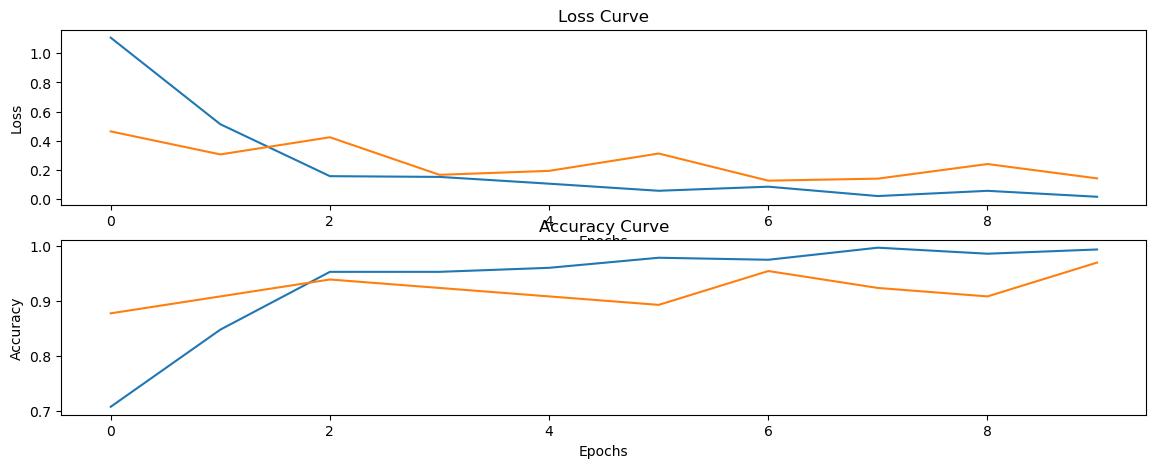

In [7]:
#please alter this path to your own path
train_data_dir = 'train_generator'
test_data_dir = 'test_generator'
img_width = 224
img_height = 224

def main():
    model = create_model_RestNet50V2(input_shape=(img_width, img_height, 3), num_classes=4)
    #model = create_model_ResNet18(input_shape=(img_width, img_height, 3), num_classes=4)
    #model = create_model_ResNet50(input_shape=(img_width, img_height, 3), num_classes=4)
    print(model.summary())

    train_generator=load_dataset(train_data_dir, img_width, img_height)
    test_generator=load_dataset(test_data_dir, img_width, img_height)

    steps_per_epoch = train_generator.n//train_generator.batch_size
    
    history=model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=10, validation_data=test_generator)
    model.evaluate(x=test_generator)

    plot_history(history)

    

if __name__ == "__main__":
    main()